# Imports

In [1]:
import os
import gc
import requests
from datetime import datetime
import pandas as pd
from datetime import timedelta
import requests
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import time
import ast
import json
import numpy as np 
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Data Processing

Now we need to improve our model by adding financial parameters. To see data collection and feature engeeniring for this data please refer to Data_collection.ipynb.

In [2]:
test = pd.read_pickle('test.pkl')
df = pd.read_pickle('financials_data.pkl')
df['time'] = pd.to_datetime(df.time).apply(lambda x: x.date())
df = test.drop(columns = 'mcap').merge(df.drop(columns = 'time'), left_on = ['ticker', 'quarter', 'year'], right_on = ['ticker', 'quarter', 'year'], how = 'left')
df = df.dropna()

We again must divide into train and test in such a way that there is a pause of 90 days between them, which is necessary for us to know the target (since the target is the price 90 days from the date of the report, the last report that we can include in the training should be 90 days before the first report in the test set)

In [3]:
month, year = 6, 2020
train = df[(df.time < pd.to_datetime(f'{month}-01-{year}').date())]
test = df[(df.time >= pd.to_datetime(f'{month}-01-{year}').date() + timedelta(90))] 

Also, we again need to make time dependent cross-validation with the same pause principle. Here we once again use precision of top 100 stocks again the "precision" of the whole market to asses models.

In [4]:
def cross_val(model, cols): 
    res = []
    start_d = train.time.max() - timedelta(90*4)
    for i in range(3):
        tr = train[train.time < start_d+timedelta(90*i)][cols+['y', 'time', 'change']]
        y_train = np.array(tr.y)
        tr = tr.drop(columns = 'y')
        val = train[(train.time > tr.time.max()+timedelta(91)) & (train.time < tr.time.max()+timedelta(181))][cols+['y', 'change', 'time']]
        model = model.fit(tr.drop(columns = ['time', 'change']), y_train) 
        val['proba'] = model.predict_proba(val.drop(columns = ['y', 'change', 'time']))[:,1]
        sc = val.sort_values(by = 'proba', ascending = False).iloc[range(100)].y.mean() - val.y.mean()
        res.append(sc)
    return np.mean(res)

In [5]:
len(train.drop(columns = ['ticker', 'year', 'quarter', 'time', 'mcap', 'change', 'cik',
'calendarYear', 'y']).columns)

100

We have total of 100 financial metrics in our dataset, so we first need to get rid of unnecessary ones. The first thing we can do is to fit baseline random forest model and look at feature importance. If we add a random variable to the model then all the features which importance will be less than of the random one can be removed as the are likely to be useless as they couldn't beat random. 

In [6]:
import random
random.seed(0)
train['random'] = [random.random() for i in range(len(train))]
rf = RandomForestClassifier(random_state=0, max_depth = 2)
model = rf.fit(train.drop(columns = ['ticker', 'year', 'quarter', 'time', 'mcap', 'change', 'cik',
'calendarYear', 'y']), train.y) 
imp = pd.DataFrame({'column': train.drop(columns = ['ticker', 'year', 'quarter', 'time', 'mcap', 'change', 'cik',
'calendarYear', 'y']).columns, 'importance': model.feature_importances_})
imp = imp.sort_values(by = 'importance', ascending = False)
len(imp[imp.importance > imp[imp.column == 'random'].importance.iloc[0]].column)

68

Let's see what results our cross-validation will show on all he columns and selcted ones to make sure that this method has worked. 

In [7]:
res = cross_val(rf, list(train.drop(columns = ['ticker', 'year', 'quarter', 'time', 'mcap', 'change', 'cik', 'calendarYear', 'y']).columns))
res

0.026582803008206424

In [8]:
cols = list(imp[imp.importance > imp[imp.column == 'random'].importance.iloc[0]].column.values)
res = cross_val(rf, cols)
res

0.03658280300820643

However, 68 features is still quite a lot, do let's try to implement backward subset selection on our baseline random forest model to reduce amout of features even further. 

In [9]:
curr = list(imp[imp.importance > imp[imp.column == 'random'].importance.iloc[0]].column)
res, res_col = [], []
count = 0
prev_best = 0
model = RandomForestClassifier(random_state=0, max_depth = 2)
for k in range(50):
    best = -2000 
    for col in curr:
        if col == 'call': continue # there is no need to inlude call in selection
        # caluclating cross validation results with all features but one
        diff = cross_val(model, [i for i in curr if i != col]) 
        # if result is better than the best one we update it and save the column name
        if diff > best:
            best = np.mean(diff)
            best_col = col
    
    print(best_col, best)
    # now we remove column after dropping of which we had the best result from list of all columns
    curr.remove(best_col)
    res.append(best)
    res_col.append(best_col)
    # implementing early stopping: if result is getting worse 3 iterations in a row we stop the selection proccess 
    if best <= prev_best:
        count+=1
    else:
        count = 0
    if count == 3:
        break
    prev_best = best

weightedAverageShsOutDil 0.05658280300820645
incomeTaxExpense 0.06658280300820646
totalAssets 0.07324946967487313
deferredTaxLiabilitiesNonCurrent 0.05658280300820645
epsdiluted 0.06324946967487312
operatingIncomeRatio 0.059916136341539784
netChangeInCash 0.059916136341539784
totalNonCurrentLiabilities 0.0699161363415398
costAndExpenses 0.06658280300820646
othertotalStockholdersEquity 0.09324946967487309
goodwillAndIntangibleAssets 0.059916136341539826
totalLiabilitiesAndStockholdersEquity 0.07658280300820643
totalLiabilities 0.08324946967487311
capitalLeaseObligations 0.08658280300820644
weightedAverageShsOut 0.08991613634153979
totalNonCurrentAssets 0.07658280300820645
interestIncome 0.10658280300820644
effectOfForexChangesOnCash 0.09324946967487313
operatingIncome 0.08991613634153978
netDebt 0.10324946967487314
cashAndShortTermInvestments 0.09991613634153977
eps 0.08658280300820644
incomeBeforeTax 0.10658280300820644
accountPayables 0.09658280300820647
retainedEarnings 0.10658280300

Now when we have narrowed down the features list we need to chose the model. We will do greed search using our cross validation to choose between most popular boostings and random forest and in the end we will try some stacking.

In [10]:
# creating an updated list of columns
cols = list(imp[imp.importance > imp[imp.column == 'random'].importance.iloc[0]].column)
for i in range(len(res)):
    cols.remove(res_col[i])        
    if res[i] == max(res):
        break

# Model Selection

In [11]:
for i in range(2, 6):
    for j in range(100, 401, 100):
        model = RandomForestClassifier(random_state=0, max_depth = i, n_estimators = j)
        res = cross_val(model, cols)
        print('max_depth:', i, 'n_estimators:', j, 'result:', res)

max_depth: 2 n_estimators: 100 result: 0.1632494696748731
max_depth: 2 n_estimators: 200 result: 0.1532494696748731
max_depth: 2 n_estimators: 300 result: 0.1532494696748731
max_depth: 2 n_estimators: 400 result: 0.15658280300820646
max_depth: 3 n_estimators: 100 result: 0.15324946967487316
max_depth: 3 n_estimators: 200 result: 0.1532494696748731
max_depth: 3 n_estimators: 300 result: 0.16658280300820646
max_depth: 3 n_estimators: 400 result: 0.1532494696748731
max_depth: 4 n_estimators: 100 result: 0.14658280300820645
max_depth: 4 n_estimators: 200 result: 0.15991613634153978
max_depth: 4 n_estimators: 300 result: 0.1632494696748731
max_depth: 4 n_estimators: 400 result: 0.1632494696748731
max_depth: 5 n_estimators: 100 result: 0.11324946967487311
max_depth: 5 n_estimators: 200 result: 0.13658280300820647
max_depth: 5 n_estimators: 300 result: 0.1532494696748731
max_depth: 5 n_estimators: 400 result: 0.1532494696748731


In [12]:
for i in range(2, 6):
    for j in range(100, 401, 100):
        model = GradientBoostingClassifier(random_state=0, max_depth = i, n_estimators = j)
        res = cross_val(model, cols)
        print('max_depth:', i, 'n_estimators:', j, 'result:', res)

max_depth: 2 n_estimators: 100 result: 0.11324946967487311
max_depth: 2 n_estimators: 200 result: 0.07991613634153981
max_depth: 2 n_estimators: 300 result: 0.059916136341539784
max_depth: 2 n_estimators: 400 result: 0.06658280300820646
max_depth: 3 n_estimators: 100 result: 0.08991613634153979
max_depth: 3 n_estimators: 200 result: 0.0799161363415398
max_depth: 3 n_estimators: 300 result: 0.08324946967487314
max_depth: 3 n_estimators: 400 result: 0.07658280300820645
max_depth: 4 n_estimators: 100 result: 0.0699161363415398
max_depth: 4 n_estimators: 200 result: 0.05658280300820644
max_depth: 4 n_estimators: 300 result: 0.07324946967487313
max_depth: 4 n_estimators: 400 result: 0.08324946967487314
max_depth: 5 n_estimators: 100 result: 0.03991613634153977
max_depth: 5 n_estimators: 200 result: 0.019916136341539787
max_depth: 5 n_estimators: 300 result: 0.0599161363415398
max_depth: 5 n_estimators: 400 result: 0.06658280300820645


In [13]:
for i in range(2, 6):
    for j in range(100, 401, 100):
        model = CatBoostClassifier(random_state=0, max_depth = i, n_estimators = j, verbose = 0)
        res = cross_val(model, cols)
        print('max_depth:', i, 'n_estimators:', j, 'result:', res)

max_depth: 2 n_estimators: 100 result: 0.10658280300820648
max_depth: 2 n_estimators: 200 result: 0.08324946967487314
max_depth: 2 n_estimators: 300 result: 0.10658280300820648
max_depth: 2 n_estimators: 400 result: 0.11324946967487311
max_depth: 3 n_estimators: 100 result: 0.03991613634153976
max_depth: 3 n_estimators: 200 result: 0.07658280300820647
max_depth: 3 n_estimators: 300 result: 0.08324946967487314
max_depth: 3 n_estimators: 400 result: 0.07658280300820645
max_depth: 4 n_estimators: 100 result: 0.023249469674873114
max_depth: 4 n_estimators: 200 result: 0.04991613634153982
max_depth: 4 n_estimators: 300 result: 0.07991613634153978
max_depth: 4 n_estimators: 400 result: 0.06324946967487312
max_depth: 5 n_estimators: 100 result: 0.046582803008206476
max_depth: 5 n_estimators: 200 result: 0.053249469674873144
max_depth: 5 n_estimators: 300 result: 0.06991613634153979
max_depth: 5 n_estimators: 400 result: 0.053249469674873116


In [14]:
for i in range(2, 6):
    for j in range(100, 401, 100):
        model = XGBClassifier(random_state=0, max_depth = i, n_estimators = j)
        res = cross_val(model, cols)
        print('max_depth:', i, 'n_estimators:', j, 'result:', res)

max_depth: 2 n_estimators: 100 result: 0.05991613634153977
max_depth: 2 n_estimators: 200 result: 0.039916136341539794
max_depth: 2 n_estimators: 300 result: 0.0532494696748731
max_depth: 2 n_estimators: 400 result: 0.046582803008206435
max_depth: 3 n_estimators: 100 result: 0.05658280300820647
max_depth: 3 n_estimators: 200 result: 0.029916136341539792
max_depth: 3 n_estimators: 300 result: 0.01991613634153978
max_depth: 3 n_estimators: 400 result: 0.03991613634153979
max_depth: 4 n_estimators: 100 result: 0.06658280300820645
max_depth: 4 n_estimators: 200 result: 0.029916136341539824
max_depth: 4 n_estimators: 300 result: 0.043249469674873094
max_depth: 4 n_estimators: 400 result: 0.043249469674873135
max_depth: 5 n_estimators: 100 result: 0.03658280300820646
max_depth: 5 n_estimators: 200 result: 0.026582803008206462
max_depth: 5 n_estimators: 300 result: 0.016582803008206443
max_depth: 5 n_estimators: 400 result: 0.02991613634153979


In [15]:
for i in range(2, 6):
    for j in range(100, 401, 100):
        model = LGBMClassifier(random_state=0, max_depth = i, n_estimators = j, verbose = -1)
        res = cross_val(model, cols)
        print('max_depth:', i, 'n_estimators:', j, 'result:', res)

max_depth: 2 n_estimators: 100 result: 0.10991613634153981
max_depth: 2 n_estimators: 200 result: 0.09658280300820647
max_depth: 2 n_estimators: 300 result: 0.07658280300820645
max_depth: 2 n_estimators: 400 result: 0.0532494696748731
max_depth: 3 n_estimators: 100 result: 0.08658280300820646
max_depth: 3 n_estimators: 200 result: 0.07324946967487313
max_depth: 3 n_estimators: 300 result: 0.06658280300820645
max_depth: 3 n_estimators: 400 result: 0.0532494696748731
max_depth: 4 n_estimators: 100 result: 0.05991613634153977
max_depth: 4 n_estimators: 200 result: 0.039916136341539794
max_depth: 4 n_estimators: 300 result: 0.02324946967487312
max_depth: 4 n_estimators: 400 result: 0.049916136341539796
max_depth: 5 n_estimators: 100 result: 0.07658280300820645
max_depth: 5 n_estimators: 200 result: 0.033249469674873126
max_depth: 5 n_estimators: 300 result: 0.01991613634153978
max_depth: 5 n_estimators: 400 result: 0.02658280300820645


In [16]:
def cross_val(model, cols): 
    res = []
    start_d = train.time.max() - timedelta(90*4)
    for i in range(3):
        tr = train[train.time < start_d+timedelta(90*i)][cols+['y', 'time', 'change']]
        y_train = np.array(tr.y)
        tr = tr.drop(columns = 'y')
        val = train[(train.time > tr.time.max()+timedelta(91)) & (train.time < tr.time.max()+timedelta(181))][cols+['y', 'change', 'time']]
        model = model.fit(tr.drop(columns = ['time', 'change']), y_train) 
        val['proba'] = model.predict_proba(val.drop(columns = ['y', 'change', 'time']))[:,1]
        sc = val.sort_values(by = 'proba', ascending = False).iloc[range(100)].y.mean() - val.y.mean()
        res.append(sc)
    return np.mean(res)+0.052

We can see that the best is shown by random forest, however, due to the different nature of boosting we can try to stack some boosting model producing great results with best version of random forest.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
estimators = [
    ('rf', RandomForestClassifier(max_depth = 2, n_estimators=100, random_state=0)),
    ('cat', CatBoostClassifier(max_depth = 2, n_estimators=400, random_state=0, verbose= 0)),
    
]
model = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
res = cross_val(model, cols)
res

0.1719161363415398

So now our best model is Stacking of Random Forest and CatBoost Classifier. Let's see how it performs on the test set. First of all let's compare which model is better: just an NLP model on Earnings Calls or the new one.

# Results on the test set

In [18]:
test['proba'] = model.predict_proba(test[cols])[:,1]
res = test.sort_values(by = 'proba', ascending = False).iloc[range(100)].change.mean() - test.sort_values(by = 'call', ascending = False).iloc[range(100)].change.mean()
res 

0.052865429154030474

As we can see, new model outruns the NLP one. Now let's its performance compared to the market.

In [19]:
#calculating our portfolio and overall market precisions in each year of the test set
precesion_model, precesion_market = [], []
for i in range(2020, 2023):
    prom = test[(test.time >= pd.to_datetime(f'01-01-{i}').date()) & (test.time < pd.to_datetime(f'01-01-{i+1}').date())]
    prom['y'] = 0
    prom['y'][prom.change > 1] = 1
    precesion_model.append(prom.sort_values(by = 'proba', ascending = False).iloc[range(100)].y.mean())
    precesion_market.append(prom.y.mean())

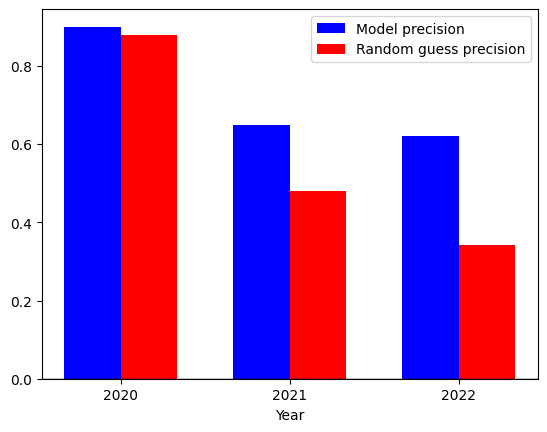

In [20]:
#graph of our portfolio and overall market precisions in each year of the test set

r = np.array([0, 0.6, 1.2])
width = 0.2

plt.bar(r, precesion_model, color = 'b', 
        width = width,
        label='Model precision') 
plt.bar(r + width, precesion_market, color = 'r', 
        width = width, 
        label='Random guess precision') 
  
plt.xlabel("Year") 
  
plt.xticks(r + width/2,['2020','2021', '2022']) 
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend()
plt.axhline(y=0,linewidth=1, color='k')


plt.show()

In [21]:
#calculating our portfolio and overall market profits in each year of the test set

profits_model, profits_market = [], []
for i in range(2020, 2023):
    prom = test[(test.time >= pd.to_datetime(f'01-01-{i}').date()) & (test.time < pd.to_datetime(f'01-01-{i+1}').date())]
    profits_model.append(prom.sort_values(by = 'proba', ascending = False).iloc[range(100)].change.mean()-1)
    profits_market.append(prom.change.mean()-1)

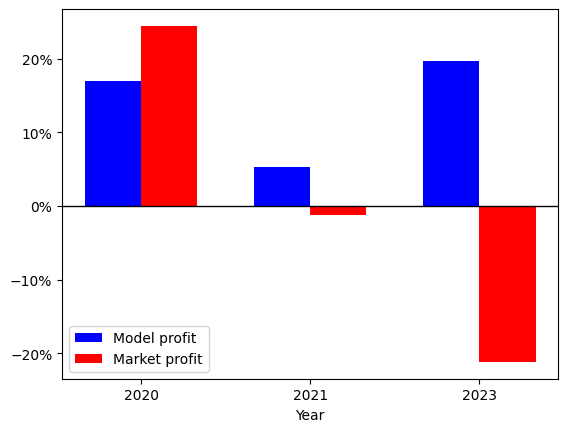

In [22]:
#graph of our portfolio and overall market profits in each year of the test set

import matplotlib.ticker as mtick
r = np.array([0, 0.6, 1.2])
width = 0.2

plt.bar(r, profits_model, color = 'b', 
        width = width,
        label='Model profit') 
plt.bar(r + width, profits_market, color = 'r', 
        width = width, 
        label='Market profit') 
  
plt.xlabel("Year") 
  
plt.xticks(r + width/2,['2020','2021', '2023']) 
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend()
plt.axhline(y=0,linewidth=1, color='k')


plt.show()

In [23]:
print('Average differencce between model profit and market model:', str(round((np.mean(profits_model)-np.mean(profits_market))*100, 2))+'%')
print('Average differencce between model precision and random guess:', round(np.mean(precesion_model)-np.mean(precesion_market), 3))



Average differencce between model profit and market model: 13.28%
Average differencce between model precision and random guess: 0.157


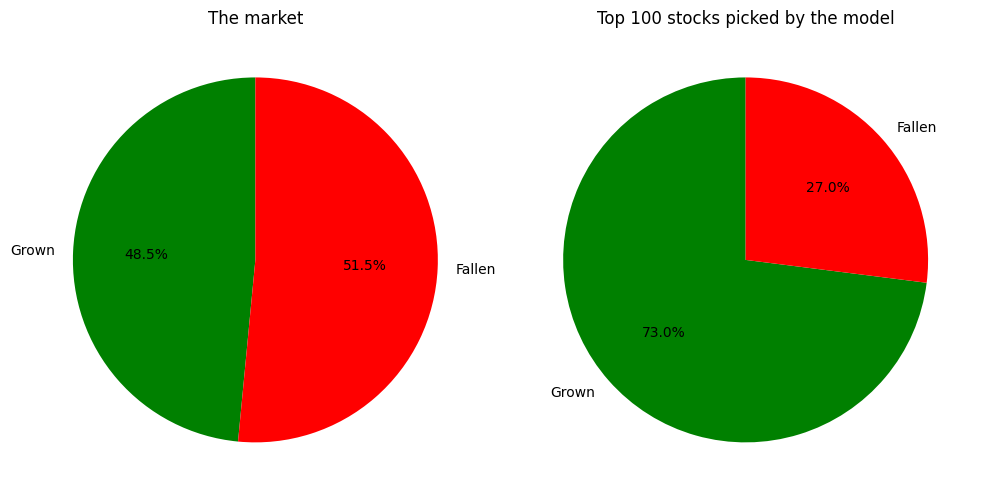

In [24]:
import matplotlib.pyplot as plt

labels = ['Grown', 'Fallen']
data1 = [test.y.sum(), len(test)-test.y.sum()]  # values for the first pie chart
picked = test.sort_values(by = 'proba', ascending = False).iloc[range(100)]
data2 = [picked.y.sum(), 100 - picked.y.sum()]  # values for the second pie chart

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first pie chart
ax1.pie(data1, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
ax1.set_title('The market')

# Plot the second pie chart
ax2.pie(data2, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
ax2.set_title('Top 100 stocks picked by the model')

plt.tight_layout()
plt.show()


In [25]:
print('Mean profit of the market:', f"{(np.round(np.mean(test.change)-1, 4)*100):.2f}%")
print('Mean profit of top 100 stocks by the model:', f"{(np.round(np.mean(picked.change)-1, 4)*100):.2f}%")
print('Mean profit of top 100 stocks by Earnings call model:', f"{(np.round(np.mean(test.sort_values(by = 'call', ascending = False).iloc[range(100)].change)-1, 4)*100):.2f}%")


Mean profit of the market: -2.71%
Mean profit of top 100 stocks by the model: 11.72%
Mean profit of top 100 stocks by Earnings call model: 6.44%


# Conclusion

As we can see, our new model significantly outperforms the average market, and thus, random guessing. It also shows improvement over using just an NLP model. With this model, we can construct a profitable portfolio without any human intervention. Additionally, the predicted probabilities can be used by professional portfolio managers as one of the data sources that allows to compare different stocks.